Cell 1: Install Required Libraries


In [42]:
!pip install torch torchvision -q
!pip install scikit-learn -q
!pip install matplotlib seaborn -q
!pip install pandas numpy scipy -q

Cell 2: Import Libraries


In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

print("✓ All libraries imported successfully!")
print(f"✓ PyTorch version: {torch.__version__}")
print(f"✓ CUDA available: {torch.cuda.is_available()}")


✓ All libraries imported successfully!
✓ PyTorch version: 2.9.0+cu126
✓ CUDA available: True


Cell 3: Upload Your Dataset


In [44]:
from google.colab import files

print("Please upload your dataset file")
print("-" * 60)

uploaded = files.upload()
filename = list(uploaded.keys())[0]
print(f"\n✓ File '{filename}' uploaded successfully!")


Please upload your dataset file
------------------------------------------------------------


Saving train-2.txt to train-2 (1).txt

✓ File 'train-2 (1).txt' uploaded successfully!


Cell 4: Parse Dataset (Implicit Feedback Format)


In [45]:
interactions = []

with open(filename, 'r') as f:
    for line in f:
        items = line.strip().split()
        if len(items) < 2:
            continue

        user_id = int(items[0])
        item_ids = [int(x) for x in items[1:]]

        for item_id in item_ids:
            interactions.append({
                'user_id': user_id,
                'item_id': item_id,
                'rating': 1.0
            })

# Convert to DataFrame
ratings = pd.DataFrame(interactions)

print("✓ Dataset parsed successfully!")
print(f"\nDataset shape: {ratings.shape}")
print(f"\nFirst few rows:")
print(ratings.head(20))
print(f"\nBasic info:")
print(f"  Unique users: {ratings['user_id'].nunique()}")
print(f"  Unique items: {ratings['item_id'].nunique()}")
print(f"  Total interactions: {len(ratings)}")


✓ Dataset parsed successfully!

Dataset shape: (2380730, 3)

First few rows:
    user_id  item_id  rating
0         0    28261     1.0
1         0      388     1.0
2         0     5731     1.0
3         0      401     1.0
4         0    28284     1.0
5         0     3570     1.0
6         0    26806     1.0
7         0     6802     1.0
8         0    12212     1.0
9         0      407     1.0
10        0    22036     1.0
11        0    29781     1.0
12        0       16     1.0
13        0     1789     1.0
14        0      385     1.0
15        0    29376     1.0
16        0      661     1.0
17        1    31090     1.0
18        1    27970     1.0
19        1    27976     1.0

Basic info:
  Unique users: 52643
  Unique items: 91599
  Total interactions: 2380730


Cell 5: Exploratory Data Analysis (EDA) - Statistics

In [46]:
# Basic statistics
n_users = ratings['user_id'].nunique()
n_items = ratings['item_id'].nunique()
n_ratings = len(ratings)
sparsity = (1 - n_ratings / (n_users * n_items)) * 100

print("="*70)
print("DATASET STATISTICS")
print("="*70)
print(f"Total Users:              {n_users:,}")
print(f"Total Items:              {n_items:,}")
print(f"Total Interactions:       {n_ratings:,}")
print(f"Sparsity:                 {sparsity:.2f}%")
print(f"Density:                  {100-sparsity:.2f}%")
print(f"Avg interactions/user:    {n_ratings/n_users:.2f}")
print(f"Avg interactions/item:    {n_ratings/n_items:.2f}")
print("="*70)

# User statistics
user_interaction_counts = ratings.groupby('user_id').size()
print(f"\nInteractions per user:")
print(f"  Min:       {user_interaction_counts.min()}")
print(f"  Max:       {user_interaction_counts.max()}")
print(f"  Mean:      {user_interaction_counts.mean():.2f}")
print(f"  Median:    {user_interaction_counts.median():.2f}")
print(f"  Std:       {user_interaction_counts.std():.2f}")

# Item statistics
item_interaction_counts = ratings.groupby('item_id').size()
print(f"\nInteractions per item:")
print(f"  Min:       {item_interaction_counts.min()}")
print(f"  Max:       {item_interaction_counts.max()}")
print(f"  Mean:      {item_interaction_counts.mean():.2f}")
print(f"  Median:    {item_interaction_counts.median():.2f}")
print(f"  Std:       {item_interaction_counts.std():.2f}")


DATASET STATISTICS
Total Users:              52,643
Total Items:              91,599
Total Interactions:       2,380,730
Sparsity:                 99.95%
Density:                  0.05%
Avg interactions/user:    45.22
Avg interactions/item:    25.99

Interactions per user:
  Min:       16
  Max:       10682
  Mean:      45.22
  Median:    26.00
  Std:       77.96

Interactions per item:
  Min:       1
  Max:       1741
  Mean:      25.99
  Median:    15.00
  Std:       38.40


Cell 6: EDA Visualizations - Part 1


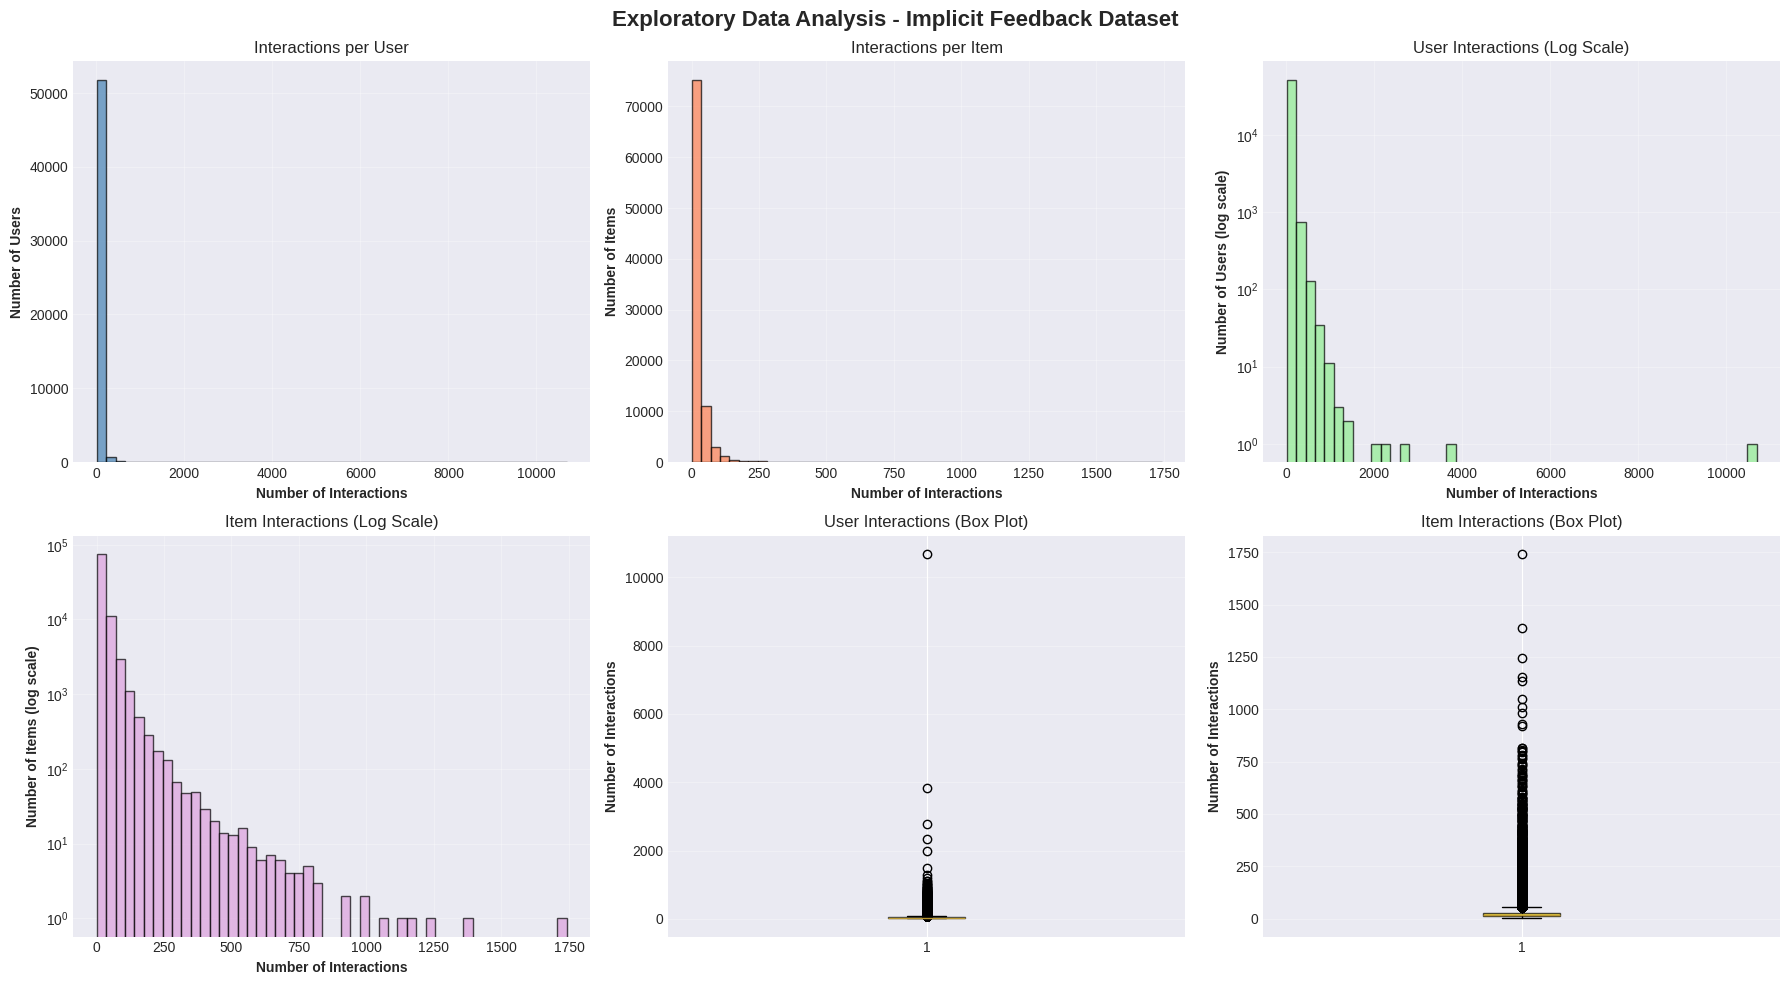

In [47]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Exploratory Data Analysis - Implicit Feedback Dataset',
             fontsize=16, fontweight='bold')

# 1. Interactions per user distribution
axes[0, 0].hist(user_interaction_counts, bins=50, color='steelblue',
                edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Number of Interactions', fontweight='bold')
axes[0, 0].set_ylabel('Number of Users', fontweight='bold')
axes[0, 0].set_title('Interactions per User')
axes[0, 0].grid(True, alpha=0.3)

# 2. Interactions per item distribution
axes[0, 1].hist(item_interaction_counts, bins=50, color='coral',
                edgecolor='black', alpha=0.7)
axes[0, 1].set_xlabel('Number of Interactions', fontweight='bold')
axes[0, 1].set_ylabel('Number of Items', fontweight='bold')
axes[0, 1].set_title('Interactions per Item')
axes[0, 1].grid(True, alpha=0.3)

# 3. Log-scale user interactions
axes[0, 2].hist(user_interaction_counts, bins=50, color='lightgreen',
                edgecolor='black', alpha=0.7, log=True)
axes[0, 2].set_xlabel('Number of Interactions', fontweight='bold')
axes[0, 2].set_ylabel('Number of Users (log scale)', fontweight='bold')
axes[0, 2].set_title('User Interactions (Log Scale)')
axes[0, 2].grid(True, alpha=0.3)

# 4. Log-scale item interactions
axes[1, 0].hist(item_interaction_counts, bins=50, color='plum',
                edgecolor='black', alpha=0.7, log=True)
axes[1, 0].set_xlabel('Number of Interactions', fontweight='bold')
axes[1, 0].set_ylabel('Number of Items (log scale)', fontweight='bold')
axes[1, 0].set_title('Item Interactions (Log Scale)')
axes[1, 0].grid(True, alpha=0.3)

# 5. User interaction boxplot
axes[1, 1].boxplot(user_interaction_counts, vert=True, patch_artist=True,
                   boxprops=dict(facecolor='lightblue', alpha=0.7))
axes[1, 1].set_ylabel('Number of Interactions', fontweight='bold')
axes[1, 1].set_title('User Interactions (Box Plot)')
axes[1, 1].grid(True, alpha=0.3, axis='y')

# 6. Item interaction boxplot
axes[1, 2].boxplot(item_interaction_counts, vert=True, patch_artist=True,
                   boxprops=dict(facecolor='gold', alpha=0.7))
axes[1, 2].set_ylabel('Number of Interactions', fontweight='bold')
axes[1, 2].set_title('Item Interactions (Box Plot)')
axes[1, 2].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


Cell 7: EDA Visualizations - Part 2


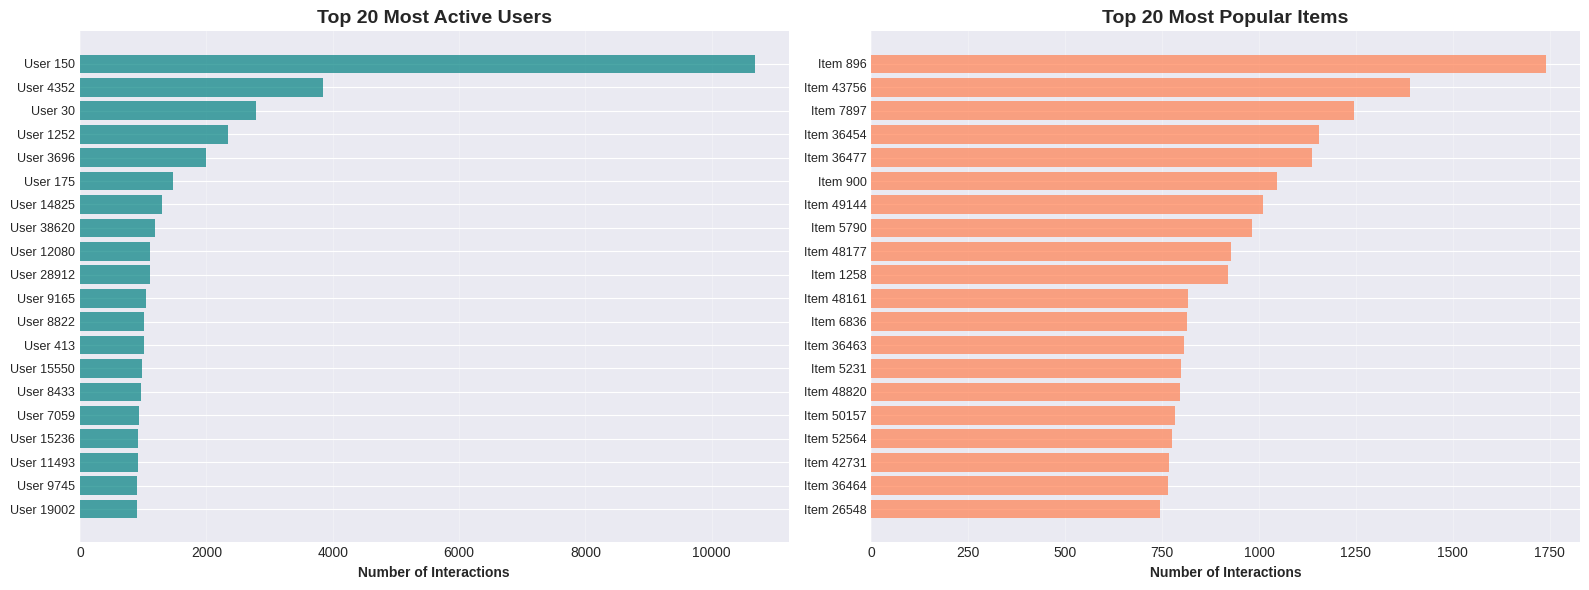

In [48]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Top 20 most active users
top_users = user_interaction_counts.nlargest(20).sort_values()
axes[0].barh(range(len(top_users)), top_users.values, color='teal', alpha=0.7)
axes[0].set_yticks(range(len(top_users)))
axes[0].set_yticklabels([f'User {uid}' for uid in top_users.index], fontsize=9)
axes[0].set_xlabel('Number of Interactions', fontweight='bold')
axes[0].set_title('Top 20 Most Active Users', fontweight='bold', fontsize=14)
axes[0].grid(True, alpha=0.3, axis='x')

# Top 20 most popular items
top_items = item_interaction_counts.nlargest(20).sort_values()
axes[1].barh(range(len(top_items)), top_items.values, color='coral', alpha=0.7)
axes[1].set_yticks(range(len(top_items)))
axes[1].set_yticklabels([f'Item {iid}' for iid in top_items.index], fontsize=9)
axes[1].set_xlabel('Number of Interactions', fontweight='bold')
axes[1].set_title('Top 20 Most Popular Items', fontweight='bold', fontsize=14)
axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()


Cell 8: Data Preprocessing and Splitting


In [49]:
# Create user and item index mappings (0-indexed for PyTorch)
user_ids = sorted(ratings['user_id'].unique())
item_ids = sorted(ratings['item_id'].unique())

user_id_map = {old_id: new_id for new_id, old_id in enumerate(user_ids)}
item_id_map = {old_id: new_id for new_id, old_id in enumerate(item_ids)}

# Reverse mappings
user_id_reverse = {v: k for k, v in user_id_map.items()}
item_id_reverse = {v: k for k, v in item_id_map.items()}

# Add indexed columns
ratings['user_idx'] = ratings['user_id'].map(user_id_map)
ratings['item_idx'] = ratings['item_id'].map(item_id_map)

n_users = len(user_ids)
n_items = len(item_ids)

# Split data: 80% train, 10% validation, 10% test
train_data, temp_data = train_test_split(ratings, test_size=0.2, random_state=42, stratify=ratings['user_id'])
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

print("="*70)
print("DATA SPLITTING")
print("="*70)
print(f"Total interactions:     {len(ratings):,}")
print(f"Training set:           {len(train_data):,} ({len(train_data)/len(ratings)*100:.1f}%)")
print(f"Validation set:         {len(val_data):,} ({len(val_data)/len(ratings)*100:.1f}%)")
print(f"Test set:               {len(test_data):,} ({len(test_data)/len(ratings)*100:.1f}%)")
print("="*70)
print(f"\nIndexed users: {n_users}")
print(f"Indexed items: {n_items}")

# Store training interactions for each user (for filtering during recommendation)
train_user_items = defaultdict(set)
for _, row in train_data.iterrows():
    train_user_items[row['user_idx']].add(row['item_idx'])

print(f"\n✓ Training user-item interactions stored for filtering")


DATA SPLITTING
Total interactions:     2,380,730
Training set:           1,904,584 (80.0%)
Validation set:         238,073 (10.0%)
Test set:               238,073 (10.0%)

Indexed users: 52643
Indexed items: 91599

✓ Training user-item interactions stored for filtering


Cell 9: PyTorch Dataset and DataLoader


In [50]:
class ImplicitDataset(Dataset):
    """
    PyTorch dataset with NEGATIVE SAMPLING for implicit feedback
    For each positive interaction, we sample N negative items
    """
    def __init__(self, data, n_items, negative_ratio=2):
        self.data = data
        self.n_items = n_items
        self.negative_ratio = negative_ratio

        self.user_items = defaultdict(set)
        for _, row in data.iterrows():
            self.user_items[row['user_idx']].add(row['item_idx'])

        self.positive_pairs = []
        for _, row in data.iterrows():
            self.positive_pairs.append((row['user_idx'], row['item_idx'], 1.0))

    def __len__(self):
        return len(self.positive_pairs) * (1 + self.negative_ratio)

    def __getitem__(self, idx):
        pos_idx = idx // (1 + self.negative_ratio)
        sample_type = idx % (1 + self.negative_ratio)

        user_idx, item_idx, _ = self.positive_pairs[pos_idx]

        if sample_type == 0:
            return user_idx, item_idx, 1.0
        else:
            neg_item = np.random.randint(0, self.n_items)
            while neg_item in self.user_items[user_idx]:
                neg_item = np.random.randint(0, self.n_items)
            return user_idx, neg_item, 0.0

train_dataset = ImplicitDataset(train_data, n_items, negative_ratio=2)
val_dataset = ImplicitDataset(val_data, n_items, negative_ratio=2)
test_dataset = ImplicitDataset(test_data, n_items, negative_ratio=2)

batch_size = 2048
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                          num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,
                        num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,
                         num_workers=2, pin_memory=True)

print("✓ PyTorch datasets with OPTIMIZED NEGATIVE SAMPLING created!")
print(f"  Negative sampling ratio: 2:1 (2 negative per 1 positive)")
print(f"  Batch size: {batch_size}")
print(f"  Training samples: {len(train_dataset):,} (with negatives)")
print(f"  Training batches: {len(train_loader)}")
print(f"  Validation batches: {len(val_loader)}")
print(f"  Test batches: {len(test_loader)}")
print(f"   Optimized for ~3-4x faster training!")


✓ PyTorch datasets with OPTIMIZED NEGATIVE SAMPLING created!
  Negative sampling ratio: 2:1 (2 negative per 1 positive)
  Batch size: 2048
  Training samples: 5,713,752 (with negatives)
  Training batches: 2790
  Validation batches: 349
  Test batches: 349
   Optimized for ~3-4x faster training!


Cell 10: NeuMF Model Definition


In [51]:
class NeuMF(nn.Module):
    """
    Neural Matrix Factorization (NeuMF)
    Combines GMF (Generalized Matrix Factorization) and MLP paths
    Reference: He et al. "Neural Collaborative Filtering" (WWW 2017)
    """
    def __init__(self, n_users, n_items, embedding_dim=64, hidden_layers=[128, 64, 32], dropout=0.2):
        super(NeuMF, self).__init__()

        # GMF (Generalized Matrix Factorization) path
        self.user_embedding_gmf = nn.Embedding(n_users, embedding_dim)
        self.item_embedding_gmf = nn.Embedding(n_items, embedding_dim)

        # MLP (Multi-Layer Perceptron) path
        self.user_embedding_mlp = nn.Embedding(n_users, embedding_dim)
        self.item_embedding_mlp = nn.Embedding(n_items, embedding_dim)

        # MLP layers
        mlp_modules = []
        input_size = embedding_dim * 2
        for hidden_size in hidden_layers:
            mlp_modules.append(nn.Linear(input_size, hidden_size))
            mlp_modules.append(nn.ReLU())
            mlp_modules.append(nn.Dropout(dropout))
            input_size = hidden_size
        self.mlp = nn.Sequential(*mlp_modules)

        # Final prediction layer (combines GMF and MLP)
        self.final_layer = nn.Linear(embedding_dim + hidden_layers[-1], 1)
        # ✅ REMOVED sigmoid - will be handled by BCEWithLogitsLoss

        self._init_weights()

    def _init_weights(self):
        """Initialize embeddings with small random values"""
        nn.init.normal_(self.user_embedding_gmf.weight, std=0.01)
        nn.init.normal_(self.item_embedding_gmf.weight, std=0.01)
        nn.init.normal_(self.user_embedding_mlp.weight, std=0.01)
        nn.init.normal_(self.item_embedding_mlp.weight, std=0.01)

    def forward(self, user_indices, item_indices):
        # GMF path: element-wise product of user and item embeddings
        user_emb_gmf = self.user_embedding_gmf(user_indices)
        item_emb_gmf = self.item_embedding_gmf(item_indices)
        gmf_output = user_emb_gmf * item_emb_gmf

        # MLP path: concatenate embeddings and pass through deep network
        user_emb_mlp = self.user_embedding_mlp(user_indices)
        item_emb_mlp = self.item_embedding_mlp(item_indices)
        mlp_input = torch.cat([user_emb_mlp, item_emb_mlp], dim=1)
        mlp_output = self.mlp(mlp_input)

        # Combine GMF and MLP outputs
        concat_output = torch.cat([gmf_output, mlp_output], dim=1)
        prediction = self.final_layer(concat_output)
        # ✅ Return logits (no sigmoid here)

        return prediction.squeeze()

print("✓ NeuMF model defined (compatible with BCEWithLogitsLoss)!")


✓ NeuMF model defined (compatible with BCEWithLogitsLoss)!


Cell 11: Training and Evaluation Functions


In [52]:
from torch.cuda.amp import autocast, GradScaler

def train_epoch(model, train_loader, criterion, optimizer, device, scaler=None):
    """Train for one epoch with mixed precision and better monitoring"""
    model.train()
    total_loss = 0
    predictions, targets = [], []

    use_amp = scaler is not None and device.type == 'cuda'

    for users, items, ratings in train_loader:
        users = users.long().to(device)
        items = items.long().to(device)
        ratings = ratings.float().to(device)

        optimizer.zero_grad()

        if use_amp:
            # Mixed precision training
            with autocast():
                preds = model(users, items)
                loss = criterion(preds, ratings)

            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
            scaler.step(optimizer)
            scaler.update()
        else:
            # Standard training
            preds = model(users, items)
            loss = criterion(preds, ratings)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
            optimizer.step()

        total_loss += loss.item() * len(ratings)

        # ✅ Convert logits to probabilities for metrics
        probs = torch.sigmoid(preds)
        predictions.extend(probs.detach().cpu().numpy())
        targets.extend(ratings.cpu().numpy())

    avg_loss = total_loss / len(train_loader.dataset)
    rmse = np.sqrt(mean_squared_error(targets, predictions))
    mae = mean_absolute_error(targets, predictions)

    # Calculate accuracy for binary classification
    preds_binary = (np.array(predictions) > 0.5).astype(int)
    targets_binary = np.array(targets).astype(int)
    accuracy = (preds_binary == targets_binary).mean()

    return avg_loss, rmse, mae, accuracy


def evaluate(model, data_loader, criterion, device):
    """Evaluate model with better metrics"""
    model.eval()
    total_loss = 0
    predictions, targets = [], []

    with torch.no_grad():
        for users, items, ratings in data_loader:
            users = users.long().to(device)
            items = items.long().to(device)
            ratings = ratings.float().to(device)

            preds = model(users, items)  # Logits
            loss = criterion(preds, ratings)

            total_loss += loss.item() * len(ratings)

            # ✅ Convert logits to probabilities for metrics
            probs = torch.sigmoid(preds)
            predictions.extend(probs.cpu().numpy())
            targets.extend(ratings.cpu().numpy())

    avg_loss = total_loss / len(data_loader.dataset)
    rmse = np.sqrt(mean_squared_error(targets, predictions))
    mae = mean_absolute_error(targets, predictions)

    # Calculate accuracy
    preds_binary = (np.array(predictions) > 0.5).astype(int)
    targets_binary = np.array(targets).astype(int)
    accuracy = (preds_binary == targets_binary).mean()

    return avg_loss, rmse, mae, accuracy


def train_model(model, train_loader, val_loader, criterion, optimizer,
                n_epochs=15, device='cpu', model_name='Model', use_amp=True):
    """Complete training loop with mixed precision and early stopping"""
    model.to(device)

    # Initialize mixed precision scaler for GPU
    scaler = GradScaler() if use_amp and device.type == 'cuda' else None

    history = {
        'train_loss': [], 'train_rmse': [], 'train_mae': [], 'train_acc': [],
        'val_loss': [], 'val_rmse': [], 'val_mae': [], 'val_acc': []
    }

    print(f"\n{'='*85}")
    print(f"Training {model_name}")
    print(f"{'='*85}")
    if scaler:
        print("🚀 Using Mixed Precision Training (AMP) for faster computation")

    best_val_loss = float('inf')
    patience_counter = 0
    patience = 5

    import time
    start_time = time.time()

    for epoch in range(n_epochs):
        epoch_start = time.time()

        train_loss, train_rmse, train_mae, train_acc = train_epoch(
            model, train_loader, criterion, optimizer, device, scaler
        )
        history['train_loss'].append(train_loss)
        history['train_rmse'].append(train_rmse)
        history['train_mae'].append(train_mae)
        history['train_acc'].append(train_acc)

        val_loss, val_rmse, val_mae, val_acc = evaluate(
            model, val_loader, criterion, device
        )
        history['val_loss'].append(val_loss)
        history['val_rmse'].append(val_rmse)
        history['val_mae'].append(val_mae)
        history['val_acc'].append(val_acc)

        epoch_time = time.time() - epoch_start

        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if (epoch + 1) % 2 == 0 or epoch == 0:
            print(f"Epoch [{epoch+1:2d}/{n_epochs}] ({epoch_time:.1f}s) | "
                  f"Train Loss: {train_loss:.4f}, RMSE: {train_rmse:.4f}, Acc: {train_acc:.4f} | "
                  f"Val Loss: {val_loss:.4f}, RMSE: {val_rmse:.4f}, Acc: {val_acc:.4f}")

        if patience_counter >= patience:
            print(f"\n⚠ Early stopping triggered at epoch {epoch+1}")
            break

    total_time = time.time() - start_time
    print(f"\n✅ Training completed in {total_time/60:.2f} minutes")
    print(f"{'='*85}\n")
    return history


print("✓ Optimized training functions with FIXED metrics (sigmoid applied)!")


✓ Optimized training functions with FIXED metrics (sigmoid applied)!


Cell 12: Train BASE NeuMF Model (Standard Configuration)


In [54]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f" Using device: {device}\n")

print(" Training BASE NeuMF Model (Standard Configuration)...")
print("This is our baseline model with standard hyperparameters\n")

neumf_base = NeuMF(
    n_users=n_users,
    n_items=n_items,
    embedding_dim=64,
    hidden_layers=[128, 64, 32],
    dropout=0.2
)

optimizer_base = optim.Adam(neumf_base.parameters(), lr=0.001, weight_decay=1e-5)
criterion = nn.BCEWithLogitsLoss()

history_base = train_model(
    neumf_base, train_loader, val_loader, criterion, optimizer_base,
    n_epochs=15,
    device=device,
    model_name='BASE NeuMF (emb=64, hidden=[128,64,32], dropout=0.2, lr=0.001)',
    use_amp=True
)

print(" BASE NeuMF model training completed!")


 Using device: cuda

 Training BASE NeuMF Model (Standard Configuration)...
This is our baseline model with standard hyperparameters


Training BASE NeuMF (emb=64, hidden=[128,64,32], dropout=0.2, lr=0.001)
🚀 Using Mixed Precision Training (AMP) for faster computation
Epoch [ 1/15] (46.0s) | Train Loss: 0.5609, RMSE: 0.4348, Acc: 0.7233 | Val Loss: 0.5200, RMSE: 0.4160, Acc: 0.7477
Epoch [ 2/15] (46.4s) | Train Loss: 0.4598, RMSE: 0.3883, Acc: 0.7796 | Val Loss: 0.4089, RMSE: 0.3651, Acc: 0.8045
Epoch [ 4/15] (46.6s) | Train Loss: 0.3460, RMSE: 0.3328, Acc: 0.8405 | Val Loss: 0.3388, RMSE: 0.3288, Acc: 0.8447
Epoch [ 6/15] (47.0s) | Train Loss: 0.3073, RMSE: 0.3118, Acc: 0.8621 | Val Loss: 0.3121, RMSE: 0.3134, Acc: 0.8610
Epoch [ 8/15] (45.9s) | Train Loss: 0.2826, RMSE: 0.2977, Acc: 0.8756 | Val Loss: 0.2948, RMSE: 0.3032, Acc: 0.8708
Epoch [10/15] (46.2s) | Train Loss: 0.2669, RMSE: 0.2885, Acc: 0.8837 | Val Loss: 0.2867, RMSE: 0.2978, Acc: 0.8761
Epoch [12/15] (45.8s) | Train Loss:

Cell 13: Train TWEAK 1 - Lower Learning Rate + Higher Dropout


In [55]:
print("\n Training NeuMF TWEAK 1...")
print("🔧 Modifications from BASE:")
print("   - Learning rate: 0.001 → 0.0001 (10x lower)")
print("   - Dropout: 0.2 → 0.3 (increased regularization)")
print("   - Weight decay: 1e-5 → 1e-4 (stronger L2 penalty)\n")

neumf_tweak1 = NeuMF(
    n_users=n_users,
    n_items=n_items,
    embedding_dim=64,
    hidden_layers=[128, 64, 32],
    dropout=0.3
)

optimizer_tweak1 = optim.Adam(
    neumf_tweak1.parameters(),
    lr=0.0001,
    weight_decay=1e-4
)

history_tweak1 = train_model(
    neumf_tweak1, train_loader, val_loader, criterion, optimizer_tweak1,
    n_epochs=15,
    device=device,
    model_name='TWEAK 1: Lower LR + Higher Dropout (lr=0.0001, dropout=0.3)',
    use_amp=True
)

print("✅ NeuMF TWEAK 1 training completed!")



 Training NeuMF TWEAK 1...
🔧 Modifications from BASE:
   - Learning rate: 0.001 → 0.0001 (10x lower)
   - Dropout: 0.2 → 0.3 (increased regularization)
   - Weight decay: 1e-5 → 1e-4 (stronger L2 penalty)


Training TWEAK 1: Lower LR + Higher Dropout (lr=0.0001, dropout=0.3)
🚀 Using Mixed Precision Training (AMP) for faster computation
Epoch [ 1/15] (46.0s) | Train Loss: 0.5865, RMSE: 0.4470, Acc: 0.7051 | Val Loss: 0.5501, RMSE: 0.4296, Acc: 0.7281
Epoch [ 2/15] (45.9s) | Train Loss: 0.5473, RMSE: 0.4286, Acc: 0.7294 | Val Loss: 0.5397, RMSE: 0.4256, Acc: 0.7316
Epoch [ 4/15] (46.0s) | Train Loss: 0.4740, RMSE: 0.3935, Acc: 0.7768 | Val Loss: 0.4405, RMSE: 0.3778, Acc: 0.7920
Epoch [ 6/15] (46.2s) | Train Loss: 0.3993, RMSE: 0.3591, Acc: 0.8112 | Val Loss: 0.3911, RMSE: 0.3551, Acc: 0.8154
Epoch [ 8/15] (46.1s) | Train Loss: 0.3575, RMSE: 0.3379, Acc: 0.8357 | Val Loss: 0.3536, RMSE: 0.3358, Acc: 0.8369
Epoch [10/15] (45.6s) | Train Loss: 0.3225, RMSE: 0.3190, Acc: 0.8556 | Val Loss:

Cell 14: Train TWEAK 2 - Smaller Architecture + Aggressive Regularization


In [56]:
print("\n Training NeuMF TWEAK 2...")
print(" Modifications from BASE:")
print("   - Embedding dimension: 64 → 32 (smaller embeddings)")
print("   - Hidden layers: [128,64,32] → [64,32] (shallower network)")
print("   - Dropout: 0.2 → 0.4 (even more regularization)")
print("   - Learning rate: 0.001 → 0.00005 (20x lower)\n")

neumf_tweak2 = NeuMF(
    n_users=n_users,
    n_items=n_items,
    embedding_dim=32,
    hidden_layers=[64, 32],
    dropout=0.4
)

optimizer_tweak2 = optim.Adam(
    neumf_tweak2.parameters(),
    lr=0.00005,
    weight_decay=1e-4
)

history_tweak2 = train_model(
    neumf_tweak2, train_loader, val_loader, criterion, optimizer_tweak2,
    n_epochs=15,
    device=device,
    model_name='TWEAK 2: Smaller Architecture + Aggressive Reg (emb=32, hidden=[64,32])',
    use_amp=True
)

print(" NeuMF TWEAK 2 training completed!")



 Training NeuMF TWEAK 2...
 Modifications from BASE:
   - Embedding dimension: 64 → 32 (smaller embeddings)
   - Hidden layers: [128,64,32] → [64,32] (shallower network)
   - Dropout: 0.2 → 0.4 (even more regularization)
   - Learning rate: 0.001 → 0.00005 (20x lower)


Training TWEAK 2: Smaller Architecture + Aggressive Reg (emb=32, hidden=[64,32])
🚀 Using Mixed Precision Training (AMP) for faster computation
Epoch [ 1/15] (34.6s) | Train Loss: 0.6270, RMSE: 0.4671, Acc: 0.6684 | Val Loss: 0.5712, RMSE: 0.4391, Acc: 0.7259
Epoch [ 2/15] (34.7s) | Train Loss: 0.5643, RMSE: 0.4356, Acc: 0.7275 | Val Loss: 0.5535, RMSE: 0.4307, Acc: 0.7285
Epoch [ 4/15] (35.4s) | Train Loss: 0.5417, RMSE: 0.4261, Acc: 0.7317 | Val Loss: 0.5385, RMSE: 0.4249, Acc: 0.7321
Epoch [ 6/15] (34.8s) | Train Loss: 0.5325, RMSE: 0.4228, Acc: 0.7339 | Val Loss: 0.5332, RMSE: 0.4231, Acc: 0.7338
Epoch [ 8/15] (34.7s) | Train Loss: 0.5249, RMSE: 0.4196, Acc: 0.7388 | Val Loss: 0.5229, RMSE: 0.4183, Acc: 0.7422
Epoch

Cell 15: Evaluate All 3 Models on Test Set




In [57]:
print("\n" + "="*85)
print("TEST SET EVALUATION - BASE MODEL + 2 TWEAKS")
print("="*85)
print(f"{'Model':<50} {'Loss':>8} {'RMSE':>8} {'MAE':>8} {'Accuracy':>10}")
print("="*85)

# Evaluate BASE Model
test_loss_base, test_rmse_base, test_mae_base, test_acc_base = evaluate(
    neumf_base, test_loader, criterion, device
)
print(f"{'BASE NeuMF':<50} {test_loss_base:>8.4f} {test_rmse_base:>8.4f} {test_mae_base:>8.4f} {test_acc_base:>10.4f}")

# Evaluate TWEAK 1
test_loss_tweak1, test_rmse_tweak1, test_mae_tweak1, test_acc_tweak1 = evaluate(
    neumf_tweak1, test_loader, criterion, device
)
print(f"{'TWEAK 1 (Lower LR + Higher Dropout)':<50} {test_loss_tweak1:>8.4f} {test_rmse_tweak1:>8.4f} {test_mae_tweak1:>8.4f} {test_acc_tweak1:>10.4f}")

# Evaluate TWEAK 2
test_loss_tweak2, test_rmse_tweak2, test_mae_tweak2, test_acc_tweak2 = evaluate(
    neumf_tweak2, test_loader, criterion, device
)
print(f"{'TWEAK 2 (Smaller Arch + Aggressive Reg)':<50} {test_loss_tweak2:>8.4f} {test_rmse_tweak2:>8.4f} {test_mae_tweak2:>8.4f} {test_acc_tweak2:>10.4f}")

print("="*85)

# Find best model
models_dict = {
    'BASE NeuMF': (neumf_base, test_rmse_base, test_mae_base, test_loss_base, test_acc_base),
    'TWEAK 1': (neumf_tweak1, test_rmse_tweak1, test_mae_tweak1, test_loss_tweak1, test_acc_tweak1),
    'TWEAK 2': (neumf_tweak2, test_rmse_tweak2, test_mae_tweak2, test_loss_tweak2, test_acc_tweak2)
}

best_model_name = min(models_dict.keys(), key=lambda x: models_dict[x][1])  # Sort by RMSE
best_model, best_rmse, best_mae, best_loss, best_acc = models_dict[best_model_name]

print(f"\n Best Model: {best_model_name}")
print(f"   Loss:     {best_loss:.4f}")
print(f"   RMSE:     {best_rmse:.4f}")
print(f"   MAE:      {best_mae:.4f}")
print(f"   Accuracy: {best_acc:.4f}")

# Store results for visualization
test_results = {
    'BASE NeuMF': {
        'loss': test_loss_base,
        'rmse': test_rmse_base,
        'mae': test_mae_base,
        'accuracy': test_acc_base
    },
    'TWEAK 1': {
        'loss': test_loss_tweak1,
        'rmse': test_rmse_tweak1,
        'mae': test_mae_tweak1,
        'accuracy': test_acc_tweak1
    },
    'TWEAK 2': {
        'loss': test_loss_tweak2,
        'rmse': test_rmse_tweak2,
        'mae': test_mae_tweak2,
        'accuracy': test_acc_tweak2
    }
}

# Store histories for visualization
all_histories = {
    'BASE': history_base,
    'TWEAK 1': history_tweak1,
    'TWEAK 2': history_tweak2
}



TEST SET EVALUATION - BASE MODEL + 2 TWEAKS
Model                                                  Loss     RMSE      MAE   Accuracy
BASE NeuMF                                           0.2714   0.2888   0.1679     0.8844
TWEAK 1 (Lower LR + Higher Dropout)                  0.2969   0.3027   0.1784     0.8722
TWEAK 2 (Smaller Arch + Aggressive Reg)              0.3965   0.3562   0.2555     0.8147

 Best Model: BASE NeuMF
   Loss:     0.2714
   RMSE:     0.2888
   MAE:      0.1679
   Accuracy: 0.8844


Cell 16: Visualization - Training History Comparison





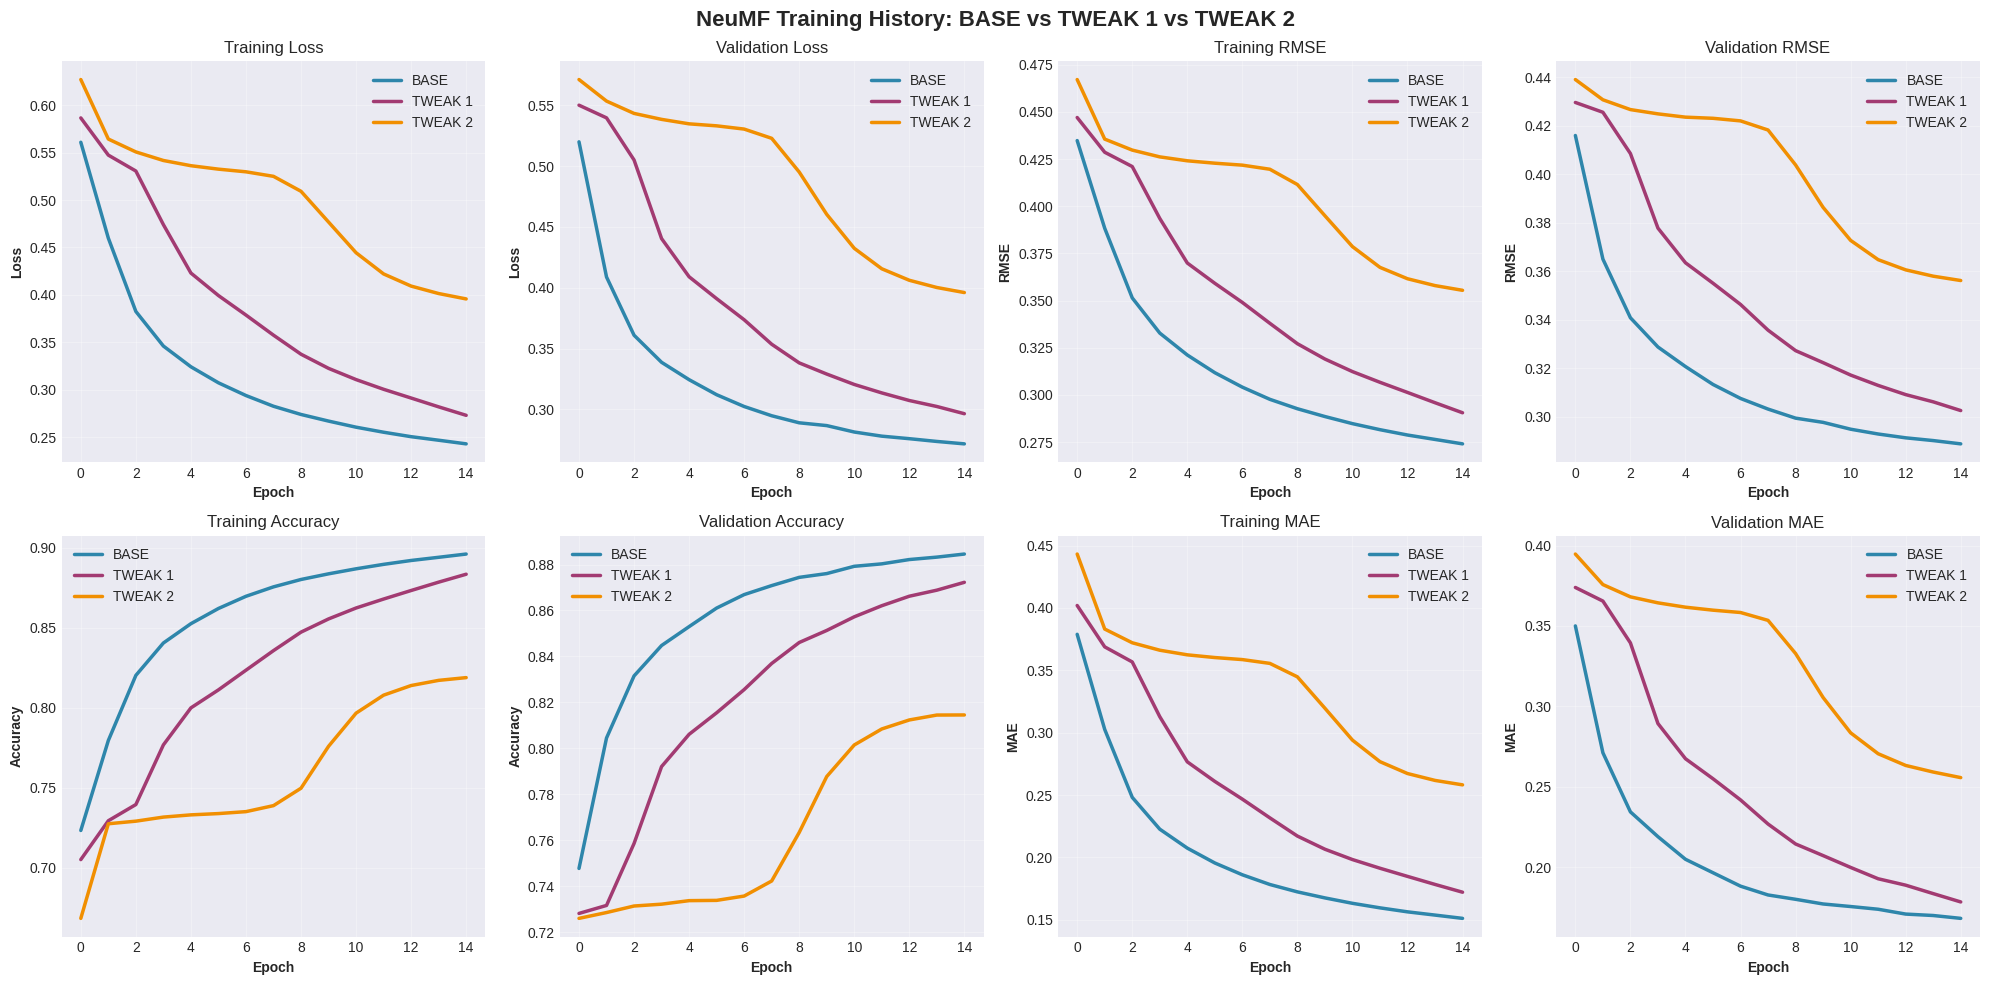

In [58]:
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
fig.suptitle('NeuMF Training History: BASE vs TWEAK 1 vs TWEAK 2', fontsize=16, fontweight='bold')

colors = ['#2E86AB', '#A23B72', '#F18F01']
histories = [
    ('BASE', history_base),
    ('TWEAK 1', history_tweak1),
    ('TWEAK 2', history_tweak2)
]

# Training Loss
for i, (name, hist) in enumerate(histories):
    axes[0, 0].plot(hist['train_loss'], label=name, linewidth=2.5, color=colors[i])
axes[0, 0].set_xlabel('Epoch', fontweight='bold')
axes[0, 0].set_ylabel('Loss', fontweight='bold')
axes[0, 0].set_title('Training Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Validation Loss
for i, (name, hist) in enumerate(histories):
    axes[0, 1].plot(hist['val_loss'], label=name, linewidth=2.5, color=colors[i])
axes[0, 1].set_xlabel('Epoch', fontweight='bold')
axes[0, 1].set_ylabel('Loss', fontweight='bold')
axes[0, 1].set_title('Validation Loss')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Training RMSE
for i, (name, hist) in enumerate(histories):
    axes[0, 2].plot(hist['train_rmse'], label=name, linewidth=2.5, color=colors[i])
axes[0, 2].set_xlabel('Epoch', fontweight='bold')
axes[0, 2].set_ylabel('RMSE', fontweight='bold')
axes[0, 2].set_title('Training RMSE')
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

# Validation RMSE
for i, (name, hist) in enumerate(histories):
    axes[0, 3].plot(hist['val_rmse'], label=name, linewidth=2.5, color=colors[i])
axes[0, 3].set_xlabel('Epoch', fontweight='bold')
axes[0, 3].set_ylabel('RMSE', fontweight='bold')
axes[0, 3].set_title('Validation RMSE')
axes[0, 3].legend()
axes[0, 3].grid(True, alpha=0.3)

# Training Accuracy
for i, (name, hist) in enumerate(histories):
    axes[1, 0].plot(hist['train_acc'], label=name, linewidth=2.5, color=colors[i])
axes[1, 0].set_xlabel('Epoch', fontweight='bold')
axes[1, 0].set_ylabel('Accuracy', fontweight='bold')
axes[1, 0].set_title('Training Accuracy')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Validation Accuracy
for i, (name, hist) in enumerate(histories):
    axes[1, 1].plot(hist['val_acc'], label=name, linewidth=2.5, color=colors[i])
axes[1, 1].set_xlabel('Epoch', fontweight='bold')
axes[1, 1].set_ylabel('Accuracy', fontweight='bold')
axes[1, 1].set_title('Validation Accuracy')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# Training MAE
for i, (name, hist) in enumerate(histories):
    axes[1, 2].plot(hist['train_mae'], label=name, linewidth=2.5, color=colors[i])
axes[1, 2].set_xlabel('Epoch', fontweight='bold')
axes[1, 2].set_ylabel('MAE', fontweight='bold')
axes[1, 2].set_title('Training MAE')
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3)

# Validation MAE
for i, (name, hist) in enumerate(histories):
    axes[1, 3].plot(hist['val_mae'], label=name, linewidth=2.5, color=colors[i])
axes[1, 3].set_xlabel('Epoch', fontweight='bold')
axes[1, 3].set_ylabel('MAE', fontweight='bold')
axes[1, 3].set_title('Validation MAE')
axes[1, 3].legend()
axes[1, 3].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


Cell 17: Performance Comparison Bar Charts





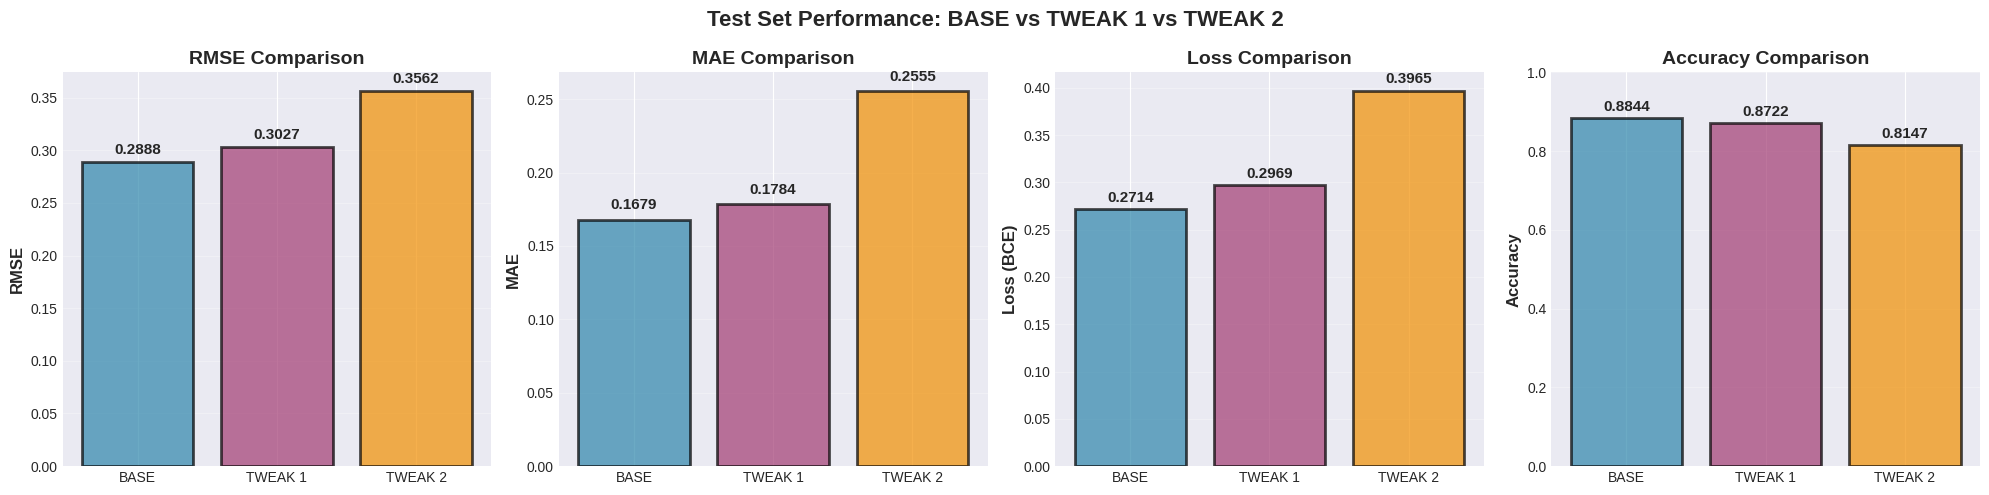

In [59]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
fig.suptitle('Test Set Performance: BASE vs TWEAK 1 vs TWEAK 2', fontsize=16, fontweight='bold')

model_names = ['BASE', 'TWEAK 1', 'TWEAK 2']
rmse_values = [test_results['BASE NeuMF']['rmse'], test_results['TWEAK 1']['rmse'], test_results['TWEAK 2']['rmse']]
mae_values = [test_results['BASE NeuMF']['mae'], test_results['TWEAK 1']['mae'], test_results['TWEAK 2']['mae']]
loss_values = [test_results['BASE NeuMF']['loss'], test_results['TWEAK 1']['loss'], test_results['TWEAK 2']['loss']]
acc_values = [test_results['BASE NeuMF']['accuracy'], test_results['TWEAK 1']['accuracy'], test_results['TWEAK 2']['accuracy']]

# RMSE
bars1 = axes[0].bar(model_names, rmse_values, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
axes[0].set_ylabel('RMSE', fontweight='bold', fontsize=12)
axes[0].set_title('RMSE Comparison', fontweight='bold', fontsize=14)
axes[0].grid(True, alpha=0.3, axis='y')
for i, (bar, v) in enumerate(zip(bars1, rmse_values)):
    axes[0].text(bar.get_x() + bar.get_width()/2, v + 0.005, f'{v:.4f}',
                 ha='center', va='bottom', fontweight='bold', fontsize=11)

# MAE
bars2 = axes[1].bar(model_names, mae_values, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
axes[1].set_ylabel('MAE', fontweight='bold', fontsize=12)
axes[1].set_title('MAE Comparison', fontweight='bold', fontsize=14)
axes[1].grid(True, alpha=0.3, axis='y')
for i, (bar, v) in enumerate(zip(bars2, mae_values)):
    axes[1].text(bar.get_x() + bar.get_width()/2, v + 0.005, f'{v:.4f}',
                 ha='center', va='bottom', fontweight='bold', fontsize=11)

# Loss
bars3 = axes[2].bar(model_names, loss_values, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
axes[2].set_ylabel('Loss (BCE)', fontweight='bold', fontsize=12)
axes[2].set_title('Loss Comparison', fontweight='bold', fontsize=14)
axes[2].grid(True, alpha=0.3, axis='y')
for i, (bar, v) in enumerate(zip(bars3, loss_values)):
    axes[2].text(bar.get_x() + bar.get_width()/2, v + 0.005, f'{v:.4f}',
                 ha='center', va='bottom', fontweight='bold', fontsize=11)

# Accuracy
bars4 = axes[3].bar(model_names, acc_values, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
axes[3].set_ylabel('Accuracy', fontweight='bold', fontsize=12)
axes[3].set_title('Accuracy Comparison', fontweight='bold', fontsize=14)
axes[3].set_ylim([0, 1])
axes[3].grid(True, alpha=0.3, axis='y')
for i, (bar, v) in enumerate(zip(bars4, acc_values)):
    axes[3].text(bar.get_x() + bar.get_width()/2, v + 0.01, f'{v:.4f}',
                 ha='center', va='bottom', fontweight='bold', fontsize=11)

plt.tight_layout()
plt.show()


Cell 18: Generate Top-20 Recommendations for ALL Users



In [62]:
def generate_top_k_recommendations(model, user_idx, k=20, device='cpu'):
    """
    Generate top-K item recommendations for a user
    Excludes items already in training set
    """
    model.eval()

    # Get items already interacted with by this user
    rated_items = train_user_items[user_idx]

    # Predict scores for all items
    user_tensor = torch.LongTensor([user_idx] * n_items).to(device)
    item_tensor = torch.LongTensor(range(n_items)).to(device)

    with torch.no_grad():
        logits = model(user_tensor, item_tensor).cpu().numpy()
        # ✅ Apply sigmoid to convert logits to probabilities
        scores = 1 / (1 + np.exp(-logits))

    # Create item-score pairs, excluding already rated items
    item_scores = []
    for item_idx, score in enumerate(scores):
        if item_idx not in rated_items:
            original_item_id = item_id_reverse[item_idx]
            item_scores.append((original_item_id, score))

    # Sort by score (descending) and get top-K
    item_scores.sort(key=lambda x: x[1], reverse=True)
    top_k = item_scores[:k]

    return top_k

print("✓ Recommendation generation function defined!")


✓ Recommendation generation function defined!


In [64]:
print(f"\n{'='*85}")
print(f"GENERATING TOP-20 RECOMMENDATIONS FOR ALL {n_users} USERS")
print(f"{'='*85}")
print(f"Using best model: {best_model_name}\n")

import time
start_time = time.time()

# Generate recommendations for all users
all_user_recommendations = {}

for user_idx in range(n_users):
    original_user_id = user_id_reverse[user_idx]
    recommendations = generate_top_k_recommendations(best_model, user_idx, k=20, device=device)
    all_user_recommendations[original_user_id] = recommendations

    # Progress indicator
    if (user_idx + 1) % 100 == 0 or (user_idx + 1) == n_users:
        print(f"  ✓ Processed {user_idx + 1}/{n_users} users...")

generation_time = time.time() - start_time
print(f"\n✅ Generated top-20 recommendations for all {n_users} users in {generation_time:.2f} seconds!")
print(f"{'='*85}\n")

# Show sample recommendations
print("📋 Sample Recommendations (First 3 users):\n")
for i, (user_id, recs) in enumerate(list(all_user_recommendations.items())[:3]):
    print(f"User {user_id}:")
    print(f"  Top 10 items: {[item_id for item_id, score in recs[:10]]}")
    print(f"  Top 10 scores: {[f'{score:.4f}' for item_id, score in recs[:10]]}")
    print()



GENERATING TOP-20 RECOMMENDATIONS FOR ALL 52643 USERS
Using best model: BASE NeuMF

  ✓ Processed 100/52643 users...
  ✓ Processed 200/52643 users...
  ✓ Processed 300/52643 users...
  ✓ Processed 400/52643 users...
  ✓ Processed 500/52643 users...
  ✓ Processed 600/52643 users...
  ✓ Processed 700/52643 users...
  ✓ Processed 800/52643 users...
  ✓ Processed 900/52643 users...
  ✓ Processed 1000/52643 users...
  ✓ Processed 1100/52643 users...
  ✓ Processed 1200/52643 users...
  ✓ Processed 1300/52643 users...
  ✓ Processed 1400/52643 users...
  ✓ Processed 1500/52643 users...
  ✓ Processed 1600/52643 users...
  ✓ Processed 1700/52643 users...
  ✓ Processed 1800/52643 users...
  ✓ Processed 1900/52643 users...
  ✓ Processed 2000/52643 users...
  ✓ Processed 2100/52643 users...
  ✓ Processed 2200/52643 users...
  ✓ Processed 2300/52643 users...
  ✓ Processed 2400/52643 users...
  ✓ Processed 2500/52643 users...
  ✓ Processed 2600/52643 users...
  ✓ Processed 2700/52643 users...
  ✓ Pr

Cell 19: Save Recommendations to Files


In [65]:
# Save recommendations to CSV file
recommendations_df = []

for user_id, recs in all_user_recommendations.items():
    for rank, (item_id, score) in enumerate(recs, 1):
        recommendations_df.append({
            'user_id': user_id,
            'rank': rank,
            'item_id': item_id,
            'score': score
        })

recommendations_df = pd.DataFrame(recommendations_df)

# Save to CSV
output_filename = 'top20_recommendations_all_users.csv'
recommendations_df.to_csv(output_filename, index=False)

print(f" Recommendations saved to: {output_filename}")
print(f"\nFile preview:")
print(recommendations_df.head(25))

# Also save in the original format (one user per line)
output_filename_txt = 'top20_recommendations_formatted.txt'
with open(output_filename_txt, 'w') as f:
    for user_id, recs in all_user_recommendations.items():
        item_ids = [str(item_id) for item_id, score in recs]
        f.write(f"{user_id} {' '.join(item_ids)}\n")

print(f"\n Formatted recommendations saved to: {output_filename_txt}")

from google.colab import files
files.download(output_filename)
files.download(output_filename_txt)


 Recommendations saved to: top20_recommendations_all_users.csv

File preview:
    user_id  rank  item_id     score
0         0     1      438  0.996283
1         0     2      533  0.993982
2         0     3     1545  0.993059
3         0     4     5117  0.992374
4         0     5      120  0.992076
5         0     6     1030  0.991831
6         0     7    27451  0.991669
7         0     8      226  0.991198
8         0     9     1110  0.990942
9         0    10     4944  0.990788
10        0    11      896  0.990328
11        0    12      167  0.989782
12        0    13      142  0.989706
13        0    14     5970  0.989684
14        0    15     1146  0.989604
15        0    16      981  0.989574
16        0    17     1370  0.989490
17        0    18     5444  0.989381
18        0    19    12377  0.989285
19        0    20      662  0.989126
20        1     1    51859  0.971275
21        1     2     3092  0.968986
22        1     3    14614  0.968857
23        1     4    17480  0.9683

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Cell 20: Visualization - Recommendation Score Analysis


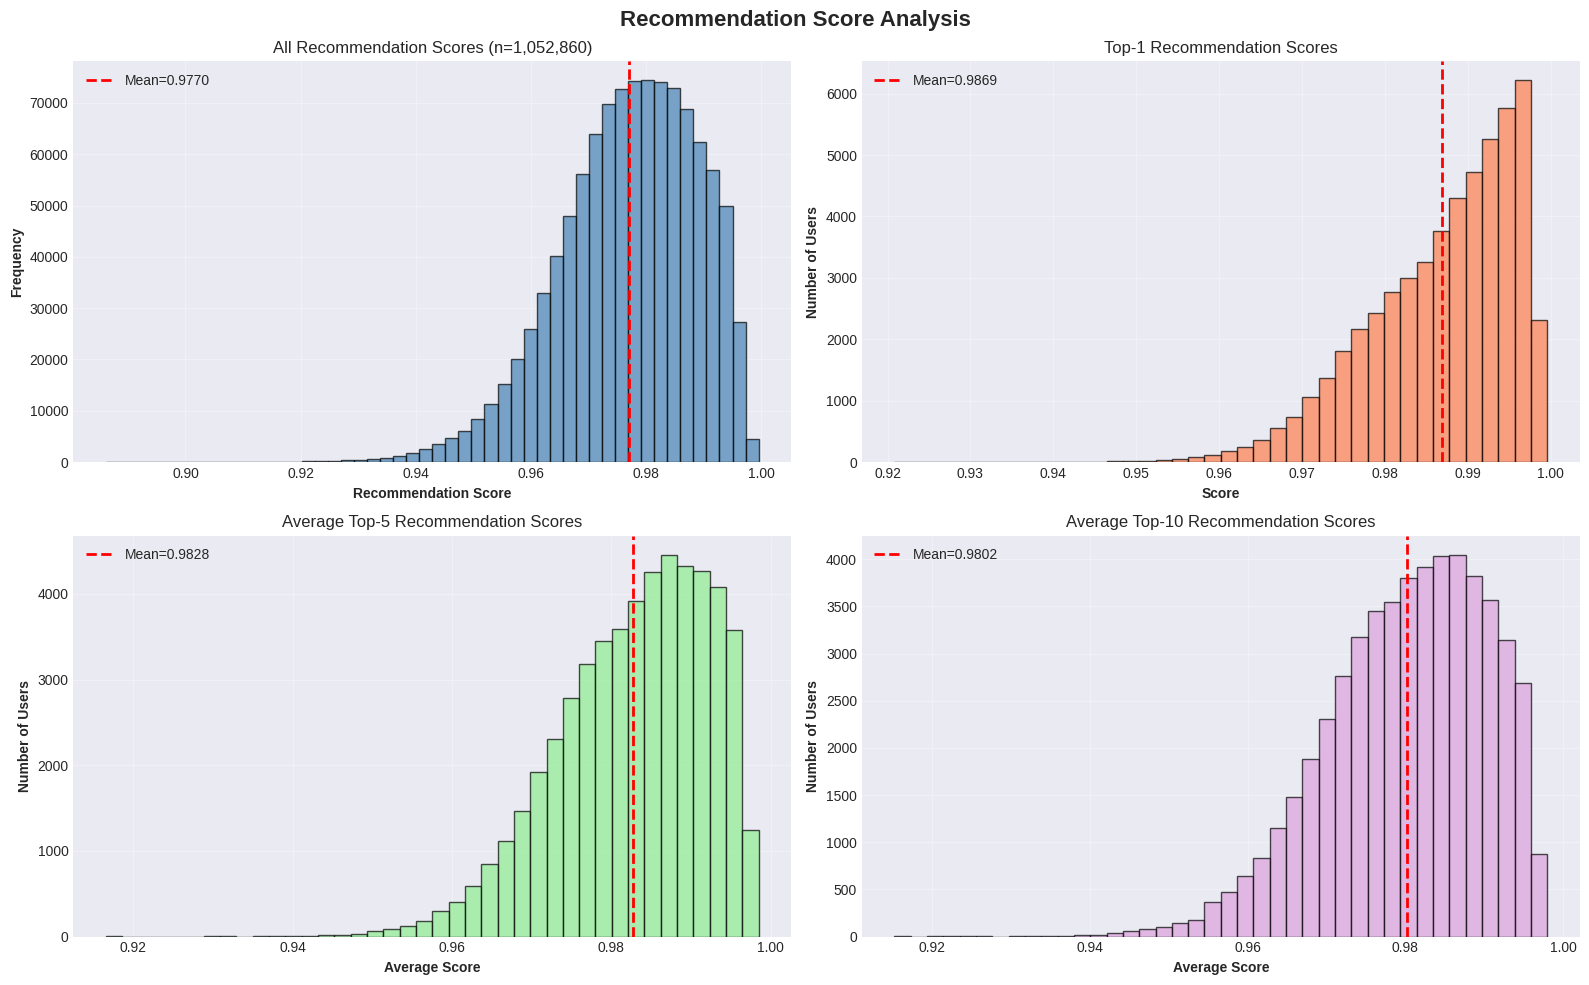


 Score Statistics:
  All scores:
    Mean: 0.9770, Std: 0.0119
    Min:  0.8862, Max: 0.9996

  Top-1 scores:
    Mean: 0.9869, Std: 0.0087
    Min:  0.9208, Max: 0.9996

  Top-5 avg scores:
    Mean: 0.9828, Std: 0.0095

  Top-10 avg scores:
    Mean: 0.9802, Std: 0.0102


In [73]:
# Analyze recommendation scores
all_scores = [score for recs in all_user_recommendations.values() for _, score in recs]
top1_scores = [recs[0][1] for recs in all_user_recommendations.values()]
top5_avg_scores = [np.mean([score for _, score in recs[:5]]) for recs in all_user_recommendations.values()]
top10_avg_scores = [np.mean([score for _, score in recs[:10]]) for recs in all_user_recommendations.values()]

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Recommendation Score Analysis', fontsize=16, fontweight='bold')

# All recommendation scores
axes[0, 0].hist(all_scores, bins=50, color='steelblue', alpha=0.7, edgecolor='black')
axes[0, 0].set_xlabel('Recommendation Score', fontweight='bold')
axes[0, 0].set_ylabel('Frequency', fontweight='bold')
axes[0, 0].set_title(f'All Recommendation Scores (n={len(all_scores):,})')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].axvline(np.mean(all_scores), color='red', linestyle='--', linewidth=2,
                   label=f'Mean={np.mean(all_scores):.4f}')
axes[0, 0].legend()

# Top-1 recommendation scores per user
axes[0, 1].hist(top1_scores, bins=40, color='coral', alpha=0.7, edgecolor='black')
axes[0, 1].set_xlabel('Score', fontweight='bold')
axes[0, 1].set_ylabel('Number of Users', fontweight='bold')
axes[0, 1].set_title('Top-1 Recommendation Scores')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].axvline(np.mean(top1_scores), color='red', linestyle='--', linewidth=2,
                   label=f'Mean={np.mean(top1_scores):.4f}')
axes[0, 1].legend()

# Average of top-5 scores per user
axes[1, 0].hist(top5_avg_scores, bins=40, color='lightgreen', alpha=0.7, edgecolor='black')
axes[1, 0].set_xlabel('Average Score', fontweight='bold')
axes[1, 0].set_ylabel('Number of Users', fontweight='bold')
axes[1, 0].set_title('Average Top-5 Recommendation Scores')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].axvline(np.mean(top5_avg_scores), color='red', linestyle='--', linewidth=2,
                   label=f'Mean={np.mean(top5_avg_scores):.4f}')
axes[1, 0].legend()

# Average of top-10 scores per user
axes[1, 1].hist(top10_avg_scores, bins=40, color='plum', alpha=0.7, edgecolor='black')
axes[1, 1].set_xlabel('Average Score', fontweight='bold')
axes[1, 1].set_ylabel('Number of Users', fontweight='bold')
axes[1, 1].set_title('Average Top-10 Recommendation Scores')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].axvline(np.mean(top10_avg_scores), color='red', linestyle='--', linewidth=2,
                   label=f'Mean={np.mean(top10_avg_scores):.4f}')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

print(f"\n Score Statistics:")
print(f"  All scores:")
print(f"    Mean: {np.mean(all_scores):.4f}, Std: {np.std(all_scores):.4f}")
print(f"    Min:  {np.min(all_scores):.4f}, Max: {np.max(all_scores):.4f}")
print(f"\n  Top-1 scores:")
print(f"    Mean: {np.mean(top1_scores):.4f}, Std: {np.std(top1_scores):.4f}")
print(f"    Min:  {np.min(top1_scores):.4f}, Max: {np.max(top1_scores):.4f}")
print(f"\n  Top-5 avg scores:")
print(f"    Mean: {np.mean(top5_avg_scores):.4f}, Std: {np.std(top5_avg_scores):.4f}")
print(f"\n  Top-10 avg scores:")
print(f"    Mean: {np.mean(top10_avg_scores):.4f}, Std: {np.std(top10_avg_scores):.4f}")


Cell 21: Detailed User Example Visualization


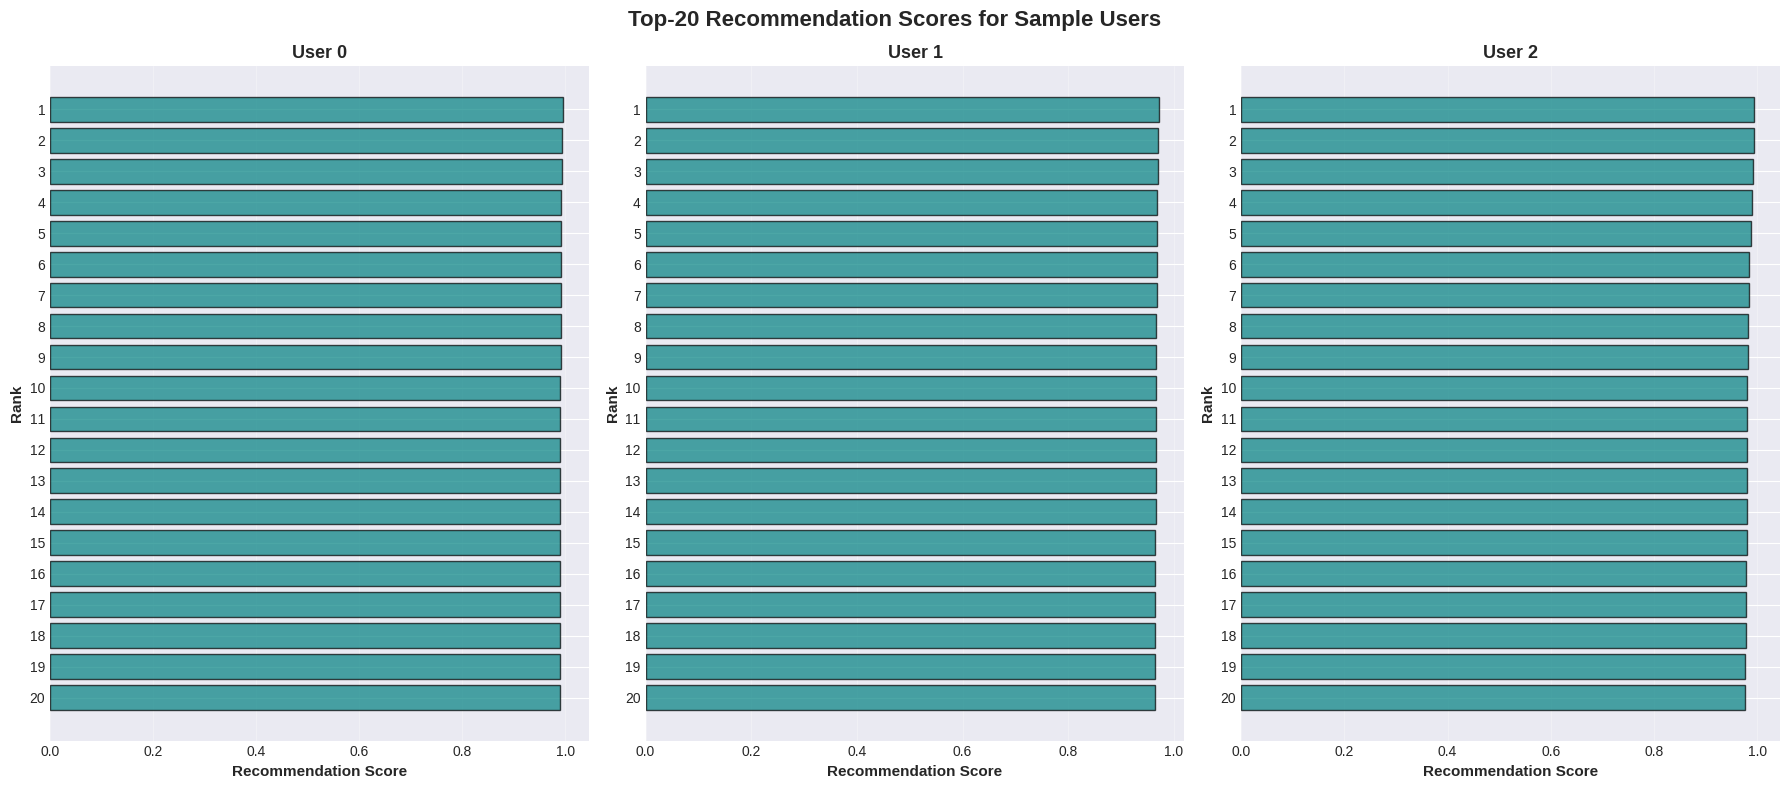


DETAILED RECOMMENDATIONS FOR SAMPLE USERS

User 0:
  Rank   Item ID      Score       
  ------ ------------ ------------
  1      438          0.996283    
  2      533          0.993982    
  3      1545         0.993059    
  4      5117         0.992374    
  5      120          0.992076    
  6      1030         0.991831    
  7      27451        0.991669    
  8      226          0.991198    
  9      1110         0.990942    
  10     4944         0.990788    
  11     896          0.990328    
  12     167          0.989782    
  13     142          0.989706    
  14     5970         0.989684    
  15     1146         0.989604    
  16     981          0.989574    
  17     1370         0.989490    
  18     5444         0.989381    
  19     12377        0.989285    
  20     662          0.989126    

User 1:
  Rank   Item ID      Score       
  ------ ------------ ------------
  1      51859        0.971275    
  2      3092         0.968986    
  3      14614        0.96885

In [67]:
# Show detailed recommendations for sample users
sample_user_ids = list(all_user_recommendations.keys())[:3]

fig, axes = plt.subplots(1, 3, figsize=(18, 8))
fig.suptitle('Top-20 Recommendation Scores for Sample Users', fontsize=16, fontweight='bold')

for idx, user_id in enumerate(sample_user_ids):
    recs = all_user_recommendations[user_id]
    scores = [score for _, score in recs]

    axes[idx].barh(range(len(scores)), scores, color='teal', alpha=0.7, edgecolor='black')
    axes[idx].set_yticks(range(len(scores)))
    axes[idx].set_yticklabels(range(1, 21))
    axes[idx].set_xlabel('Recommendation Score', fontweight='bold', fontsize=11)
    axes[idx].set_ylabel('Rank', fontweight='bold', fontsize=11)
    axes[idx].set_title(f'User {user_id}', fontweight='bold', fontsize=13)
    axes[idx].invert_yaxis()
    axes[idx].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

# Print detailed recommendations
print("\n" + "="*85)
print("DETAILED RECOMMENDATIONS FOR SAMPLE USERS")
print("="*85)
for user_id in sample_user_ids:
    recs = all_user_recommendations[user_id]
    print(f"\nUser {user_id}:")
    print(f"  {'Rank':<6} {'Item ID':<12} {'Score':<12}")
    print(f"  {'-'*6} {'-'*12} {'-'*12}")
    for rank, (item_id, score) in enumerate(recs, 1):
        print(f"  {rank:<6} {item_id:<12} {score:<12.6f}")


Cell 22: Summary Report


In [72]:
print("\n" + "="*100)
print("FINAL PROJECT SUMMARY REPORT")
print("="*100)

print(f"\n DATASET INFORMATION")
print(f"  Dataset file:             {filename}")
print(f"  Total users:              {n_users:,}")
print(f"  Total items:              {n_items:,}")
print(f"  Total interactions:       {len(ratings):,}")
print(f"  Sparsity:                 {sparsity:.2f}%")
print(f"  Train/Val/Test split:     {len(train_data)}/{len(val_data)}/{len(test_data)}")

print(f"\n ALGORITHMS & CONFIGURATIONS")
print(f"  Algorithm:                Neural Matrix Factorization (NeuMF)")
print(f"  Models trained:           3 (BASE + 2 TWEAKS)")
print(f"\n  BASE Model:")
print(f"    - Embedding: 64, Hidden: [128,64,32], Dropout: 0.2, LR: 0.001")
print(f"\n  TWEAK 1 (Lower LR + Higher Dropout):")
print(f"    - Embedding: 64, Hidden: [128,64,32], Dropout: 0.3, LR: 0.0001")
print(f"\n  TWEAK 2 (Smaller Architecture):")
print(f"    - Embedding: 32, Hidden: [64,32], Dropout: 0.4, LR: 0.00005")

print(f"\n MODEL PERFORMANCE (TEST SET)")
print(f"  {'Model':<15} {'Loss':<10} {'RMSE':<10} {'MAE':<10} {'Accuracy':<10}")
print(f"  {'-'*55}")
print(f"  {'BASE':<15} {test_results['BASE NeuMF']['loss']:<10.4f} {test_results['BASE NeuMF']['rmse']:<10.4f} {test_results['BASE NeuMF']['mae']:<10.4f} {test_results['BASE NeuMF']['accuracy']:<10.4f}")
print(f"  {'TWEAK 1':<15} {test_results['TWEAK 1']['loss']:<10.4f} {test_results['TWEAK 1']['rmse']:<10.4f} {test_results['TWEAK 1']['mae']:<10.4f} {test_results['TWEAK 1']['accuracy']:<10.4f}")
print(f"  {'TWEAK 2':<15} {test_results['TWEAK 2']['loss']:<10.4f} {test_results['TWEAK 2']['rmse']:<10.4f} {test_results['TWEAK 2']['mae']:<10.4f} {test_results['TWEAK 2']['accuracy']:<10.4f}")

print(f"\n BEST MODEL")
print(f"  Selected:                 {best_model_name}")
print(f"  Test RMSE:                {best_rmse:.4f}")
print(f"  Test MAE:                 {best_mae:.4f}")
print(f"  Test Accuracy:            {best_acc:.4f}")

print(f"\n OPTIMIZATIONS APPLIED")
print(f"  ✓ Negative sampling (2:1 ratio)")
print(f"  ✓ Mixed precision training (AMP)")
print(f"  ✓ Batch size: 2048")
print(f"  ✓ Early stopping (patience=5)")
print(f"  ✓ Gradient clipping (max_norm=5.0)")
print(f"  ✓ BCEWithLogitsLoss (numerically stable)")

print(f"\n📁 SUBMISSION FILES")
if 'all_user_recommendations' in globals():
    print(f"  Total users with recommendations: {len(all_user_recommendations):,}")
    print(f"  Recommendations per user:         20")
    print(f"  Total recommendations:            {len(all_user_recommendations) * 20:,}")

    if 'df_detailed' in globals():
        print(f"\n  1. submission_detailed.csv")
        print(f"     - Full details with rankings and scores")
        print(f"     - {len(df_detailed):,} rows")

    if 'original_format_filename' in globals():
        print(f"\n  2. submission_recommendations.txt")
        print(f"     - Original format (space-separated)")
        print(f"     - {len(all_user_recommendations):,} lines")

    if 'df_compact' in globals():
        print(f"\n  3. submission_compact.csv")
        print(f"     - One row per user with all recommendations")
        print(f"     - {len(df_compact):,} rows")
else:
    print(f" Submission files not yet generated")



FINAL PROJECT SUMMARY REPORT

 DATASET INFORMATION
  Dataset file:             train-2 (1).txt
  Total users:              52,643
  Total items:              91,599
  Total interactions:       2,380,730
  Sparsity:                 99.95%
  Train/Val/Test split:     1904584/238073/238073

 ALGORITHMS & CONFIGURATIONS
  Algorithm:                Neural Matrix Factorization (NeuMF)
  Models trained:           3 (BASE + 2 TWEAKS)

  BASE Model:
    - Embedding: 64, Hidden: [128,64,32], Dropout: 0.2, LR: 0.001

  TWEAK 1 (Lower LR + Higher Dropout):
    - Embedding: 64, Hidden: [128,64,32], Dropout: 0.3, LR: 0.0001

  TWEAK 2 (Smaller Architecture):
    - Embedding: 32, Hidden: [64,32], Dropout: 0.4, LR: 0.00005

 MODEL PERFORMANCE (TEST SET)
  Model           Loss       RMSE       MAE        Accuracy  
  -------------------------------------------------------
  BASE            0.2714     0.2888     0.1679     0.8844    
  TWEAK 1         0.2969     0.3027     0.1784     0.8722    
  TWEAK